# STAT 430 Final Project
- By Kevin Chen & Zhongyi Liu

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet

from pyclustertend import hopkins

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score

## Introduction

Steam is a popular video game platform, and its main revenue source is the commission of selling games. Therefore, it is crucial to attract users with games they enjoy (spend a lot of time on) so that users will keep purchasing games on Steam.

As the video game market grows 5% annually, we start to see many data analysis about Steam. Most of them are focused on EDA and the recommender system (see links below), and there lacks analysis on user behavior. Our objective is to fill in this gap and provide insights on user behaviors.

https://towardsdatascience.com/steam-recommendation-systems-4358917288eb

https://nycdatascience.com/blog/student-works/web-scraping/steam-whats-game/

https://medium.com/@ruochenzhong/steam-game-market-data-analysis-5c97ffe2dd6f

This analysis gives insights on user preference of game genres. Since there is no pre-defined labels separating the users, it is best to use unsupervised learning to find insights.

### Bibliography

Chiu, J. (2017, May 16). Steam - What's your Game? NYC Data Science Academy. https://nycdatascience.com/blog/student-works/web-scraping/steam-whats-game/.

Liang, Y. (2020, June 23). Steam Recommendation Systems. https://towardsdatascience.com/steam-recommendation-systems-4358917288eb.

Zhong, R. (2020, April 27). Steam Game Market Data Analysis. Medium. https://medium.com/@ruochenzhong/steam-game-market-data-analysis-5c97ffe2dd6f.

## Data Information

We will use 3 datasets in this project, links are shown below. 

User activity dataset: https://www.kaggle.com/tamber/steam-video-games

Game basic information: https://www.kaggle.com/nikdavis/steam-store-games?select=steam.csv

Game tag/genre information: https://www.kaggle.com/nikdavis/steam-store-games?select=steamspy_tag_data.csv

All datasets collect data from web scraping Steam game stores and public Steam user profiles. Some datasets uses the Steamspy API, a third-part API that also scrapes data from Steam.

Then, we will perform feature engineering before performing EDA and modellings.

The next few slides contain the preview of these 3 datasets.

In [2]:
df_game_basic_raw = pd.read_csv('steam.csv')
df_game_tag_raw = pd.read_csv('steamspy_tag_data.csv')
# Drops the last column (which only contains 0)
df_user_activity_raw = pd.read_csv('steam-200k.csv', header = None, names = ['user_id', 'name', 'activity', 'hours', 'to_drop']).drop(columns = 'to_drop')

In [3]:
df_game_basic_raw.head(3)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99


In [4]:
df_game_tag_raw.head(5)

,appid,1980s,1990s,2.5d,2d,2d_fighter,360_video,3d,3d_platformer,3d_vision,...,warhammer_40k,web_publishing,werewolves,western,word_game,world_war_i,world_war_ii,wrestling,zombies,e_sports
0,10,144,564,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,550
1,20,0,71,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5,122,0,0,0
3,40,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,50,0,77,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df_user_activity_raw.head(10)

,user_id,name,activity,hours
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0
5,151603712,Spore,play,14.9
6,151603712,Fallout New Vegas,purchase,1.0
7,151603712,Fallout New Vegas,play,12.1
8,151603712,Left 4 Dead 2,purchase,1.0
9,151603712,Left 4 Dead 2,play,8.9


## Data Pre-processing and Feature Engineering

This section includes data pre-processing and feature engineering for 3 datasets

We will use them to create 2 new datasets, one for users, another for games

### Engineering the game basic info dataset

Input: "df_game_basic_raw"

Process:

- Subsets useful columns

- Create new feature: "release_year" (original: "release_date")

- Create new feature: "positive_rating_rate"

Output: "df_game_basic"

#### Subset useful columns

In [6]:
df_game_basic = df_game_basic_raw[['appid', 
                                   'name', 
                                   'release_date', 
                                   'positive_ratings', 
                                   'negative_ratings', 
                                   'average_playtime', 
                                   'median_playtime', 
                                   'owners', 
                                   'price']]

#### Create new feature: "release_year"

In [7]:
# Use insert() to avoid performing on the view instead of the df itself
df_game_basic.insert(2, 'release_year', pd.to_datetime(df_game_basic['release_date']).dt.year)
df_game_basic = df_game_basic.drop(columns = 'release_date')

#### Create the "positive_rating_rate feature"

In [8]:
# Use insert() to avoid performing on the view instead of the df itself
df_game_basic.insert(5, 'positive_rating_rate', df_game_basic['positive_ratings']/(df_game_basic['positive_ratings']+df_game_basic['negative_ratings']))

#### Output: "df_game_basic"

In [9]:
df_game_basic.head(5)

,appid,name,release_year,positive_ratings,negative_ratings,positive_rating_rate,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000,124534,3339,0.973888,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999,3318,633,0.839787,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003,3416,398,0.895648,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001,1273,267,0.826623,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999,5250,288,0.947996,624,415,5000000-10000000,3.99


### Engineering the game tags dataset

Input: "df_game_tag_raw"

Process:

- Select the most common genres/tags among all

- Perform one-hot encoding on tags

Output: "df_game_tag_main"

#### Number of tags in the dataset

In [10]:
df_game_tag_raw.shape

(29022, 372)

There are 371 tags in total (first column is id), so we need to select part of them to reduce dimension.

#### Selecting common tags

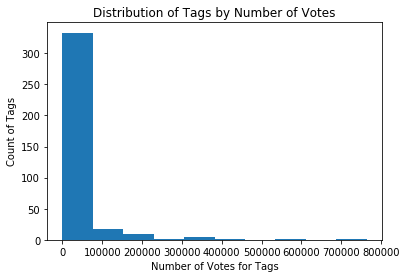

In [11]:
# Calculate column sums for tags
tag_col_sum = df_game_tag_raw.drop(columns = "appid").sum(axis = 0)
# Visualization
plt.hist(tag_col_sum)
plt.title('Distribution of Tags by Number of Votes')
plt.xlabel('Number of Votes for Tags')
plt.ylabel('Count of Tags')
plt.show()

From the histogram above, we can see that most tags contains less than 100,000 votes, and a few very popular tags contains much more votes. Therefore, we can use the 5 most common tags to effectively reduce the dimentionality while still representing most votes/games.

Below are details of the tags with more than 100,000 votes, and we will use the top 5:

In [12]:
# Details of the selected tags
tag_col_sum_main = tag_col_sum[tag_col_sum > 100000].sort_values(ascending = False)
tag_col_sum_main

action              763849
indie               730458
adventure           563927
multiplayer         415341
singleplayer        403390
casual              327532
rpg                 318176
strategy            312526
open_world          312337
simulation          282366
free_to_play        279564
survival            217127
first_person        210418
fps                 209224
co_op               205249
shooter             200226
atmospheric         199678
great_soundtrack    182345
sandbox             161617
story_rich          156399
early_access        135436
horror              121378
sci_fi              111666
funny               109080
third_person        108115
2d                  105843
dtype: int64

#### Perform one-hot encoding on top 5 tags

In [13]:
# Create list to subset top 5 tags
temp = list(tag_col_sum_main[:5].index)
# Subset tags dataframe
df_game_tag_main = df_game_tag_raw[temp]
# Change the non-zero values into 1
df_game_tag_main = np.ceil(df_game_tag_main/np.max(np.max(df_game_tag_main))).astype(int)
# Add the 'appid' column
df_game_tag_main.insert(0, 'appid', df_game_tag_raw['appid'])

#### Output: "df_game_tag_main"

In [14]:
df_game_tag_main.head(5)

,appid,action,indie,adventure,multiplayer,singleplayer
0,10,1,0,0,1,0
1,20,1,0,1,1,0
2,30,1,0,0,1,1
3,40,1,0,0,1,0
4,50,1,0,1,0,1


### Join both datasets to create the game dataset

Input: "df_game_basic_raw", "df_game_tag_main"

Process:

- Join two datasets on game names, missing values in df_game_tag_main are replaced by 0

Output: "df_game"

In [15]:
df_game = pd.merge(df_game_basic, df_game_tag_main, on = 'appid', how = 'inner')
# Drop duplicated rows (by name)
df_game.drop_duplicates(subset ="name", keep = False, inplace = True)
df_game.head(5)

,appid,name,release_year,positive_ratings,negative_ratings,positive_rating_rate,average_playtime,median_playtime,owners,price,action,indie,adventure,multiplayer,singleplayer
0,10,Counter-Strike,2000,124534,3339,0.973888,17612,317,10000000-20000000,7.19,1,0,0,1,0
1,20,Team Fortress Classic,1999,3318,633,0.839787,277,62,5000000-10000000,3.99,1,0,1,1,0
2,30,Day of Defeat,2003,3416,398,0.895648,187,34,5000000-10000000,3.99,1,0,0,1,1
3,40,Deathmatch Classic,2001,1273,267,0.826623,258,184,5000000-10000000,3.99,1,0,0,1,0
4,50,Half-Life: Opposing Force,1999,5250,288,0.947996,624,415,5000000-10000000,3.99,1,0,1,0,1


### Create user dataset

Input: "df_user_activity_raw"

Process:

- Create "df_user" by collapsing the long format

- Create new features: "owned_games", "played_games", "played_games_prop", and "total_playtime"

- Remove users that never played these 5 genres

Output: "df_user"

**CAUTION: ABOUT HALF OF THE USER ACTIVITY DATASET DOES NOT HAVE A CORRESPONDING DF_GAME ENTRY, SO PLAYTIME UNDER EACH TAG MIGHT BE INCONCLUSIVE**

In [16]:
# Join df_user_activity_raw and df_game to create a more detailed dataset
df_user_activity_and_game = pd.merge(df_user_activity_raw, df_game, on = 'name', how = 'left')

# Extract unique user id, only part of them will be added to the user dataset
unique_user_id = df_user_activity_raw.user_id.unique()

# Lists to store features to create
user_id_list = []
owned_games_list = []
played_games_list = []
total_playtime_list = []
tags_to_df = []

for user_id in unique_user_id:
    # Subset of rows that belongs to this user
    temp = df_user_activity_and_game[df_user_activity_and_game['user_id'] == user_id]  
    # Further subset of rows that are play data
    temp_2 = temp[temp['activity'] == 'play']
    # Further subset of columns that are tag features
    temp_3 = temp_2[df_game_tag_main.columns].drop(columns = 'appid')
    # Change temp_3 to hours spent under each tag
    temp_3 = temp_3.apply(lambda x: x * temp['hours'], axis = 0)
    # Calculate hours spent under each tag by the user, stored in temp_4
    temp_4 = temp_3.sum(axis = 0)
    
    # Record this user's data only if total hours under all tags > 0
    if np.sum(temp_4 != 0) == 0:
        continue
    else:
        user_id_list.append(user_id)
        owned_games_list.append(sum(temp['activity'] == 'purchase'))
        played_games_list.append(sum(temp['activity'] == 'play'))
        total_playtime_list.append(sum(temp[temp['activity'] == 'play']['hours']))
        tags_to_df.append(list(temp_4))

df_user = pd.DataFrame()
df_user.insert(0, 'user_id', user_id_list)
df_user.insert(1, 'owned_games', owned_games_list)
df_user.insert(2, 'played_games', played_games_list)
df_user.insert(3, 'played_games_prop', df_user['played_games']/df_user['owned_games'])
df_user.insert(4, 'total_playtime', total_playtime_list)
df_user = pd.concat([df_user, pd.DataFrame(tags_to_df, columns = df_game_tag_main.drop('appid', axis = 1).columns)], axis = 1)

#### Output: "df_user"

In [17]:
df_user.head(5)

,user_id,owned_games,played_games,played_games_prop,total_playtime,action,indie,adventure,multiplayer,singleplayer
0,151603712,40,26,0.650000,439.9,116.5,27.6,122.7,27.7,122.2
1,187131847,1,1,1.000000,2.3,2.3,0.0,0.0,2.3,0.0
2,59945701,43,22,0.511628,467.8,45.1,26.1,38.5,28.5,45.8
3,53875128,505,197,0.390099,1346.4,592.5,281.2,578.9,465.3,623.8
4,140954425,1,1,1.000000,13.0,13.0,0.0,0.0,13.0,0.0


### Engineering the user dataset

Input: "df_user"

Process:

- Remove extremely inactive users (total playtime < 3 hours or played games <= 1)

- Change playtime under each tag into percentages of total playtime

- Remove excessive features

Output: "X" (used for model training)

When the user is inactive, it is pointless to draw any insight from the user's activity because the data is not representative of the user's true preference at all.

Different users have vastly different total playtime (3 hours to 6000+ hours). To better gauge user's preferences among different genres, we need to divide them by the toal playtime to scale the data.

#### Remove extremely inactive users

In [18]:
df_real_user = df_user[(df_user['total_playtime'] > 3) & 
                       (df_user['played_games'] > 1)].reset_index(drop = True)

#### Change playtime to precentage

In [19]:
df_user_score = df_real_user.copy()
for i in range(df_user_score.shape[0]):
    df_user_score.iloc[i,5:] = df_user_score.iloc[i,:]/df_real_user.iloc[i, 4]

#### Remove excessive features

In [20]:
X = df_user_score.copy().drop(columns = ["user_id",'owned_games','played_games','played_games_prop','total_playtime']).reset_index(drop = True)

#### Output: "X"

In [21]:
X.head(5)

,action,indie,adventure,multiplayer,singleplayer
0,0.264833,0.062742,0.278927,0.062969,0.277790
1,0.096409,0.055793,0.082300,0.060923,0.097905
2,0.440062,0.208853,0.429961,0.345588,0.463310
3,0.037301,0.037301,0.000000,0.037301,0.037301
4,0.351230,0.125280,0.125280,0.351230,0.125280


### Preview of X

In [22]:
X

,action,indie,adventure,multiplayer,singleplayer
0,0.264833,0.062742,0.278927,0.062969,0.277790
1,0.096409,0.055793,0.082300,0.060923,0.097905
2,0.440062,0.208853,0.429961,0.345588,0.463310
3,0.037301,0.037301,0.000000,0.037301,0.037301
4,0.351230,0.125280,0.125280,0.351230,0.125280
5,0.963265,0.000000,0.359184,0.963265,0.359184
6,0.698798,0.031109,0.049226,0.697319,0.023494
7,0.356301,0.203989,0.121034,0.153672,0.251133
8,0.005170,0.000000,0.005170,0.005170,0.005170
9,0.496673,0.496673,0.462409,0.462409,0.496673


## Exploratory Data Analysis

### "played_games_prop", "total_playtime", "owned_games", and "played_games"

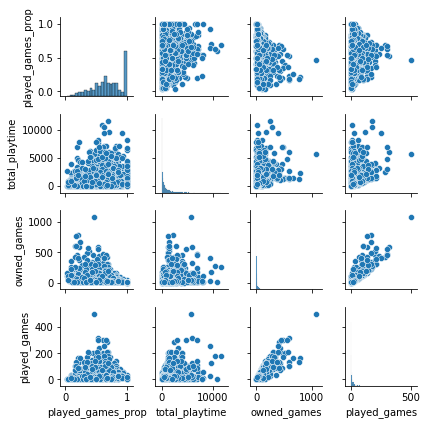

In [23]:
sns.pairplot(df_real_user, vars = ['played_games_prop', 'total_playtime', 'owned_games', 'played_games'], height = 1.5)
plt.show()

There are a few insights from the pair plot above:

- Most users have played either 50%-80% or 100% of their owned games.

- Steam user's behavior is heavily skewed: most players owns < 200 games and plays < 2500 hours, but a few hardcore users spend a lot of time and money on Steam games.

- The proportion of games played is independent of playtime and number of games owned/played.

### Playtime under each tag

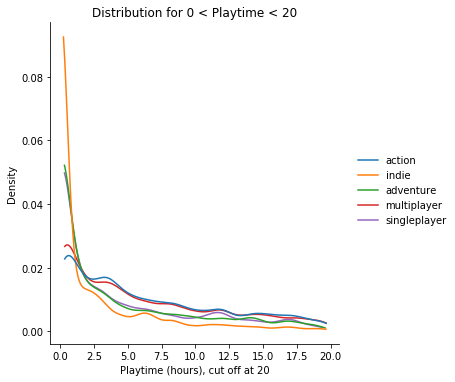

In [24]:
temp = df_real_user[['action', 'indie', 'adventure', 'multiplayer', 'singleplayer']]
sns.displot(temp[temp < 20].dropna(axis = 0), kind = 'kde', bw_adjust = 0.5, cut = -0.5)
plt.title('Distribution for 0 < Playtime < 20')
plt.xlabel('Playtime (hours), cut off at 20')
plt.show()

Most users only spend less than 3 hours on these type of games, but there are a few hardcore users that spend thousands of hours.

### Feature Correlation

Since many tags are actually correlated with the others (e.g. most action games need multiplayers), we want to explore the correlation between pairs of current attributes.

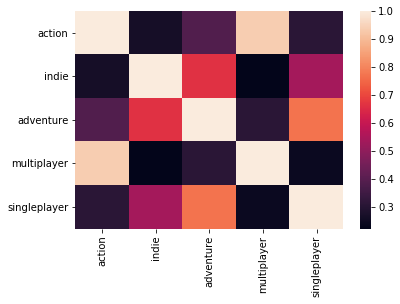

In [25]:
sns.heatmap(X.corr())
plt.show()

In [26]:
X.corr()

,action,indie,adventure,multiplayer,singleplayer
action,1.000000,0.268044,0.390714,0.937990,0.310843
indie,0.268044,1.000000,0.663706,0.224102,0.540620
adventure,0.390714,0.663706,1.000000,0.310049,0.770371
multiplayer,0.937990,0.224102,0.310049,1.000000,0.245452
singleplayer,0.310843,0.540620,0.770371,0.245452,1.000000


From the plot we can conclude that some tags are highly correlated. For example, "action" and "multiplayer" have a correlation of 0.94.

### Scaling and Standarizing Data?

From the dataset information shown below, mean and std for all features are in similar range. So there is **no need to scale or standarize data**.

In [27]:
X.describe()

,action,indie,adventure,multiplayer,singleplayer
count,3983.000000,3983.000000,3983.000000,3983.000000,3983.000000
mean,0.543138,0.166331,0.278764,0.520982,0.275855
std,0.366053,0.266650,0.318016,0.371706,0.309872
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.174416,0.000000,0.006022,0.143824,0.008509
50%,0.569752,0.023856,0.145029,0.521480,0.148876
75%,0.933223,0.219726,0.464324,0.918256,0.466667
max,1.000000,1.000000,1.000000,1.000000,1.000000


## Pre-Analysis Questions

- Current dataset is clusterable according to the TSNE plots with a perplexity of 40. Also, we will use a perplexity of 40 to visualize clustering result if needed in the next section.
- Underlying structure:
    - a. About 3 clusters showing in the last TSNE plots with perplexity of 40.
    - b. Three clusters have somewhat spherical shape.
    - c. The cluster is not balanced in size. This finding is not suprising because each kind of game is designed for target customers but some are preferred by more people. The sparsities for all clusters are also different.
    - d. The top left cluster is seperated from the others, but the seperation between other two clusters are not so clear. There exists some noise points.

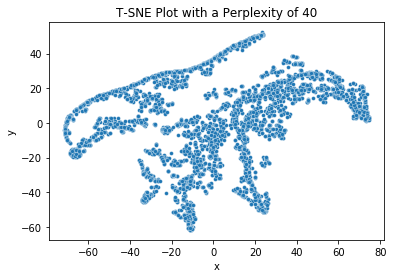

In [28]:
tsne = TSNE(n_components = 2, perplexity = 40, random_state = 1000)
data_tsne = tsne.fit_transform(X)
tsne_df = pd.DataFrame(data_tsne, columns = ['x', 'y'])
sns.scatterplot(x = 'x', y = 'y', data = tsne_df, s = 15)
plt.title('T-SNE Plot with a Perplexity of 40')
plt.show()

## Algorithm Selection Motivation

The three clusters visually detected from tsne plot are not perfectly spherical, however, they are convex and staisfy the rule that smaller eucliean distance, similar the points. Thus, centroid-based algorithm like K-Means can probably identify the clustering structure. Hierarchical Clustering algorithm allows several different linkages to determine the similarity or dissmilarity between points for constructing hierarchical relationship among points or clusters. Single linkage might deal with the linear shape cluster showing in the top left of tsne plot, while ward linkage tends to identify the cluster in the middle part. As a summary, the models applied and evaluated for the user dataset are as follows:

- K-Means
- Hierarchical Clustering

## Clustering Using K-Means

### Model Parameter Selection

In [29]:
cluster_num_list=range(2,15)
avg_inertia_list=[]
avg_sil_list = []
for k in cluster_num_list:
    sub_inertia_list=[]
    sub_sil_list=[]
    for i in range(0,3):
        kmeans=KMeans(n_clusters=k).fit(X)
        sub_inertia_list.append(kmeans.inertia_)
        sub_sil_list.append(silhouette_score(X, kmeans.labels_))
    avg_inertia_list.append(np.average(sub_inertia_list))
    avg_sil_list.append(np.average(sub_sil_list))

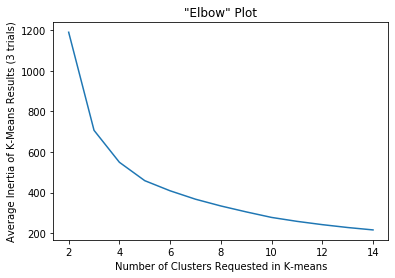

In [30]:
plt.plot(cluster_num_list,avg_inertia_list)
plt.title('"Elbow" Plot')
plt.xlabel('Number of Clusters Requested in K-means')
plt.ylabel('Average Inertia of K-Means Results (3 trials)')
plt.show()

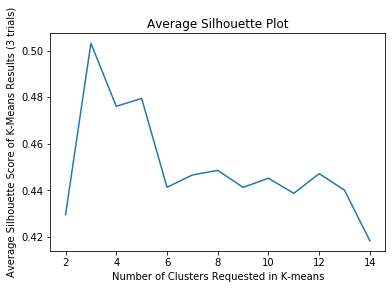

In [31]:
plt.plot(cluster_num_list,avg_sil_list)
plt.title('Average Silhouette Plot')
plt.xlabel('Number of Clusters Requested in K-means')
plt.ylabel('Average Silhouette Score of K-Means Results (3 trials)')
plt.show()

Elbow plot with Inertial against number of clusters is shown above. Average inertial levels off after k =4 or 5 in the plot for average inertia. Also, the average silhouette score reaches the maximum value when k is around 4. **Therefore, we are going to set k = 4 for K-Means alogorithm.**

### Clustering Results

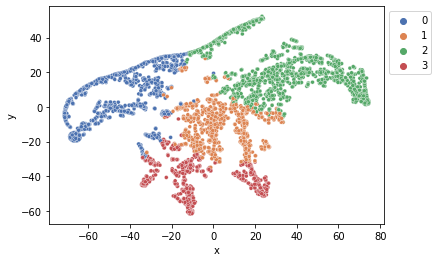

In [32]:
# K-means model
k = 4
kmeans = KMeans(n_clusters = k, random_state = 1000).fit(X)
# t-SNE plot
plot_df = tsne_df.copy()
plot_df['Labels'] = kmeans.labels_
sns.scatterplot(x = 'x', y = 'y', hue = 'Labels', palette = sns.color_palette("deep", k), data = plot_df, s = 15)
plt.legend(bbox_to_anchor = (1,1))
plt.show()

According to cluster results shown in the tsne plot above, the clustering structer is not the same as expected in preliminary analysis. However, the predicted clusters are in similar sparsities from the tsne plot. 

### Discussion

In [33]:
kmeans.cluster_centers_

array([[0.90191956, 0.03561636, 0.07209912, 0.90015715, 0.08706491],
       [0.4875093 , 0.23537305, 0.42117889, 0.42980415, 0.46421744],
       [0.13516322, 0.04494814, 0.08084597, 0.1251223 , 0.09136327],
       [0.90312243, 0.52509348, 0.81655081, 0.86997857, 0.70161796]])

In [34]:
X.columns

Index(['action', 'indie', 'adventure', 'multiplayer', 'singleplayer'], dtype='object')

The four cluster centers show the common features of corresponding cluster:

- Cluster 0: Persons who prefer to play game with tags "action" and "multiplayer".
- Cluster 1: Persons who share middle interest in the games except "indie" games.
- Cluster 2: Persons who are not interested the five types of games.
- Cluster 3: Persons who are addicted to these games but like the action, adventure, and multiplayer game the most.

With the cluster results, we are able to recommend games that some other users in the same group have played to target users. The example will be shown in the last section.

## Clustering Using Hierachical Clustering

### Model Parameter Selection

Silhouette scores using different number of clusters and linkages are compared in this section. It can be observed that ward linkage perform the best when the number of clusters range from 2 to 8. In this case, clustering results the dataset with ward linkage and number of cluster of 4, 5 and 6 for further examination.

In [35]:
nb_clusters = list(range(2,8))
linkages = ['single', 'complete', 'ward', 'average']

silhouette_scores = np.zeros(shape=(len(linkages), len(nb_clusters)))

for i, l in enumerate(linkages):
    for j, nbc in enumerate(nb_clusters):
        ag = AgglomerativeClustering(n_clusters=nbc, affinity='euclidean', linkage=l)
        label_pred = ag.fit_predict(X)
        sls = silhouette_score(X, label_pred, random_state=1000)
        silhouette_scores[i, j] = sls

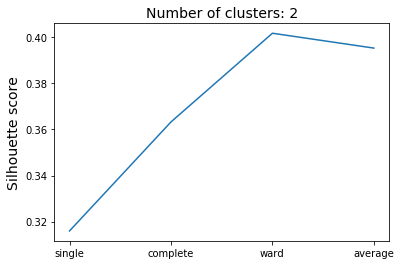

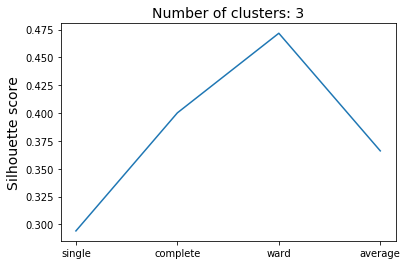

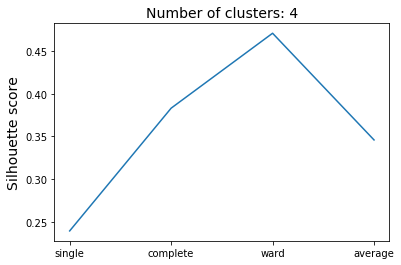

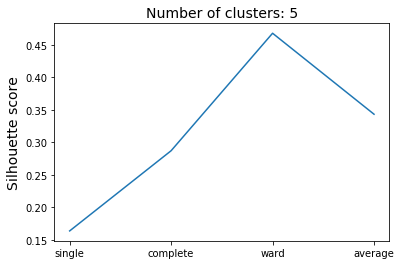

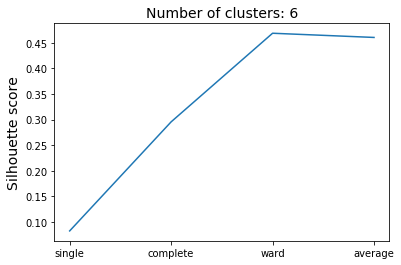

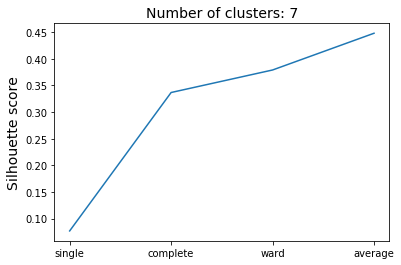

In [36]:
for i in range(len(nb_clusters)):
    plt.plot(silhouette_scores[:, i])
    plt.ylabel('Silhouette score', fontsize=14)
    plt.title('Number of clusters: {}'.format(nb_clusters[i]), fontsize=14)
    plt.xticks(np.arange(len(linkages)), linkages)
    plt.show()

In [37]:
pd.DataFrame(silhouette_scores, 
             columns = ['2 Clusters', '3 Clusters', '4 Clusters', 
                        '5 Clusters', '6 Clusters', '7 Clusters'], 
             index = ['Single', 'Complete', 'Ward', 'Average'])

,2 Clusters,3 Clusters,4 Clusters,5 Clusters,6 Clusters,7 Clusters
Single,0.315960,0.294119,0.239361,0.163602,0.082592,0.076994
Complete,0.363272,0.400214,0.383055,0.286948,0.295635,0.336635
Ward,0.401770,0.471743,0.470801,0.467636,0.468769,0.378879
Average,0.395321,0.366051,0.345868,0.343077,0.460570,0.447806


### Further Examination

- From the dendogram below, when n_cluster=4, the clustering is relatively balanced.
- According to the tsne plots shown below, when the number of clusters increase, the algorithm tends to seperate the Cluster 0 from the first tsne plot. What is expected is that the Cluster 0 could be broken down along x axis in tsne plot to seperate clusters horizontally, however, such expectation is not achieved. So, n_cluster = 4 is used instead.

In [38]:
dm = pdist(X, metric='euclidean')
Z = linkage(dm, method='ward')

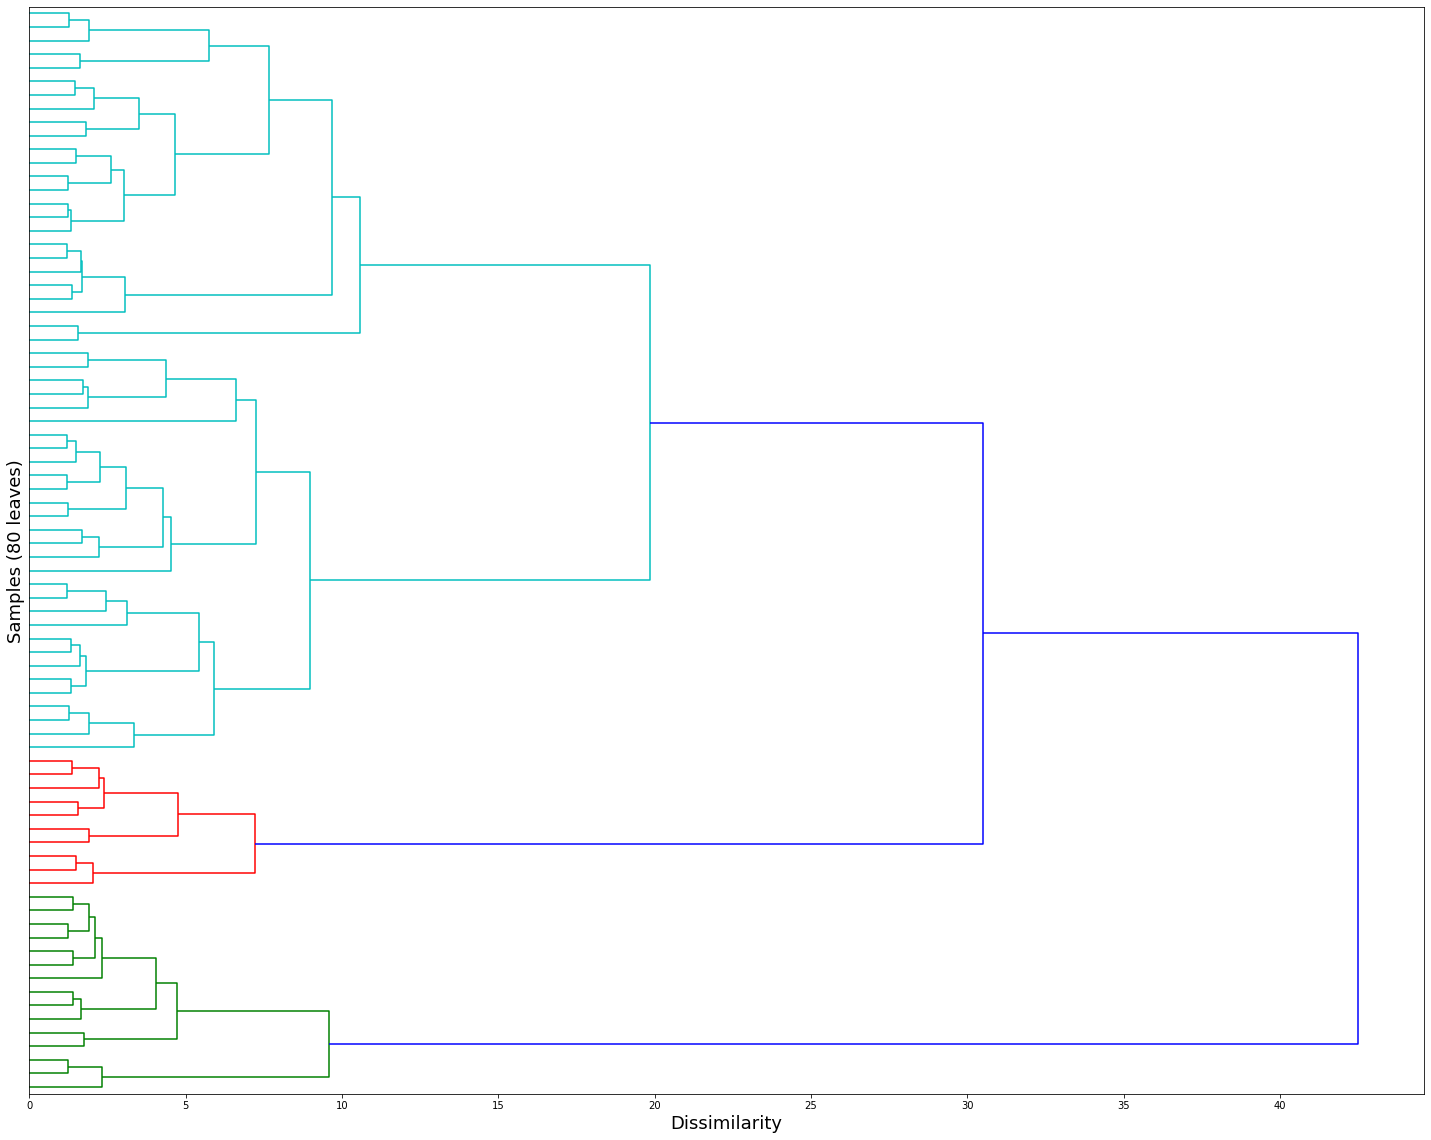

In [39]:
fig, ax = plt.subplots(figsize=(25, 20))
d = dendrogram(Z, orientation='right', truncate_mode='lastp', p=80, no_labels=True, ax=ax)
ax.set_xlabel('Dissimilarity', fontsize=18)
ax.set_ylabel('Samples (80 leaves)', fontsize=18)
plt.show()

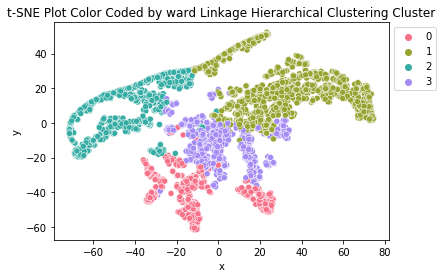

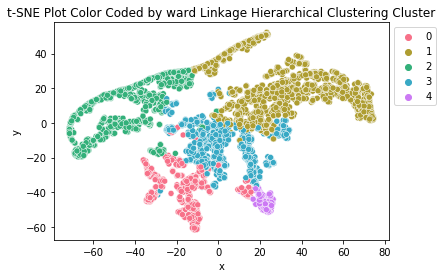

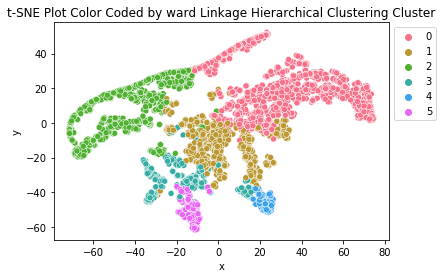

In [40]:
l = "ward"
for n in [4,5,6]:
   
    ag = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage=l)
    label_pred = ag.fit_predict(X)

    label_df = pd.Series(label_pred, name='Label', index=X.index)
    plot_df = pd.concat([tsne_df, label_df], axis=1)

    # Show the results of the clustering
    sns.scatterplot(x='x',y='y', hue='Label', palette=sns.color_palette("husl", n),data=plot_df)
    plt.title('t-SNE Plot Color Coded by %s Linkage Hierarchical Clustering Cluster'%l)
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

### Clustering Result

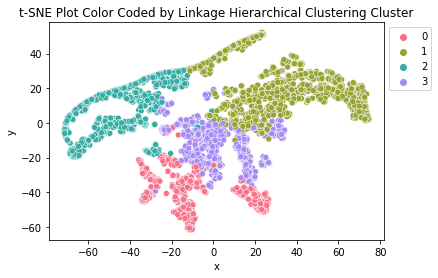

In [41]:
ag = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
label_pred = ag.fit_predict(X)

label_df = pd.Series(label_pred, name='Label', index=X.index)
plot_df = pd.concat([tsne_df, label_df], axis=1)

# Show the results of the clustering
sns.scatterplot(x='x',y='y', hue='Label', palette=sns.color_palette("husl", 4),data=plot_df)
plt.title('t-SNE Plot Color Coded by Linkage Hierarchical Clustering Cluster')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

## Post Analysis

### Separation and Cohesion

Both clustering predicted by KMeans and Agglomerative Clustering have silhouette score about 0.5, which represents good combination of cohesion and separation. But from the tsne plot, we can know that the seperation is not perfect.

In [42]:
print("Silhouette score of KMeans:", silhouette_score(X, kmeans.labels_, random_state=1000))
print("Silhouette score of Agglomerative Clustering:", silhouette_score(X, ag.fit_predict(X), random_state=1000))

Silhouette score of KMeans: 0.47603459392299186
Silhouette score of Agglomerative Clustering: 0.4708005955580269


### Cluster Attributes

#### KMeans

- Attribute "action" and "multiplayer" can distinguish Cluster 1 and 2 out of Cluster 0 and Cluster 3.
- Attribute "indie" can tell the difference between Cluster 1 and others.
- Attribute "adventure" and "singleplayer" can be used to identify Cluster 1 and Cluster 3.

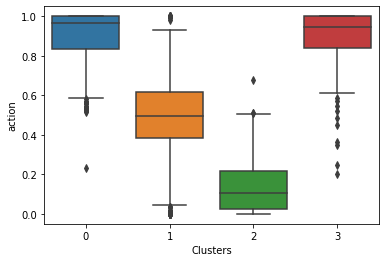

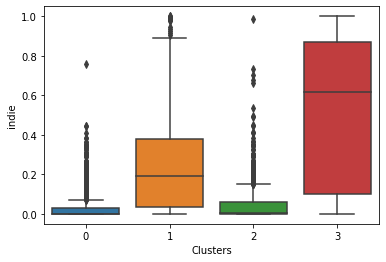

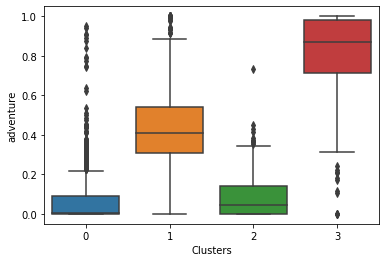

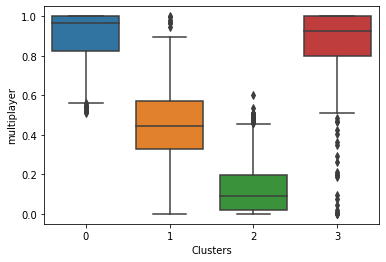

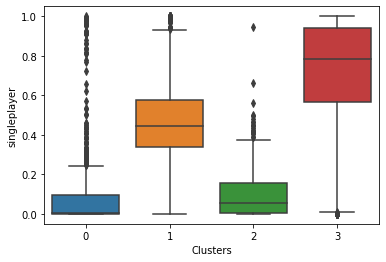

In [43]:
KM_att_df = X.copy()
KM_att_df["Clusters"] = kmeans.labels_
for att in KM_att_df.columns[0:len(KM_att_df.columns)-1]:
    sns.boxplot(x='Clusters', y=att, data=KM_att_df)
    plt.show()

#### Agglomerative Clustering

- Attribute "action" and "multiplayer" can distinguish Cluster 1 and 3 out of Cluster 0 and 2.
- Attribute "adventure" and "singleplayer" can reveal the difference between Cluster 0 and Cluster 2.
- Attribute "indie" can somewhat distinguish Cluster 0 and Cluster 3.

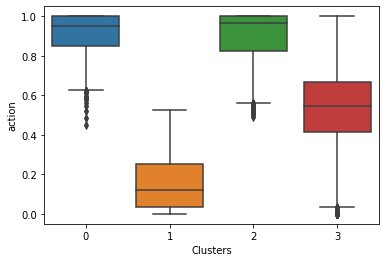

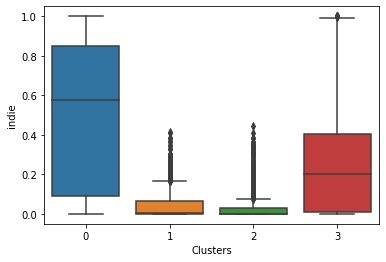

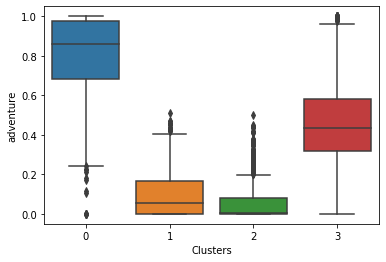

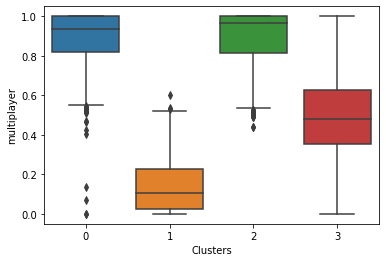

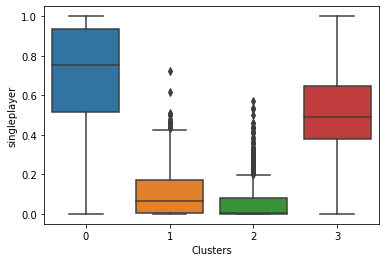

In [44]:
AG_att_df = X.copy()
AG_att_df["Clusters"] = ag.fit_predict(X)
for att in KM_att_df.columns[0:len(AG_att_df.columns)-1]:
    sns.boxplot(x='Clusters', y=att, data=AG_att_df)
    plt.show()

## Analysis Summary

### Algorithm Comparison

From the tsne plot shown below, we can observe that the clustering results of two algorithms are similar. Also, the adjusted rand score between KMeans and Agglomerative Clustering is 0.81 and close to 1.0, which means their results are quite similar. Since both algorithms are trying to reduce the cluster inertial, similar clustering results are resonable.

In [45]:
alg_com = tsne_df.copy()
alg_com["KM_labels"] = kmeans.labels_
alg_com['AG_labels'] = ag.fit_predict(X)
alg_com.head()

,x,y,KM_labels,AG_labels
0,24.063358,0.258460,2,1
1,39.492222,17.643034,2,1
2,-0.157067,-8.260790,1,3
3,51.098938,18.750879,2,1
4,-1.915971,28.621771,2,1


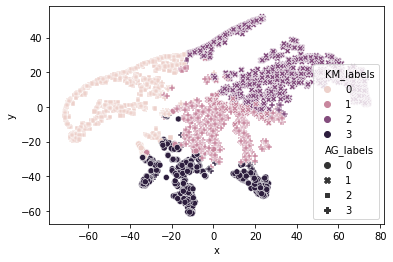

In [46]:
sns.scatterplot(data=alg_com, x='x',y='y',hue='KM_labels', style = 'AG_labels')
plt.show()

In [47]:
adjusted_rand_score(alg_com['KM_labels'], alg_com['AG_labels'])

0.8119189298285326

### Summary and Application

In this project, we successfully cluster the user game preferences. According to the clustering, we are able to recommend some games that have been played by other people in the same cluster. Let us take a look at an example on the clustering generated by KMeans algorithm.

First, put the results together with user_id information.

In [48]:
KM_result_df = df_user_score.copy()
KM_result_df['Clusters'] = kmeans.labels_
KM_result_df.head()

,user_id,owned_games,played_games,played_games_prop,total_playtime,action,indie,adventure,multiplayer,singleplayer,Clusters
0,151603712,40,26,0.650000,439.9,0.264833,0.062742,0.278927,0.062969,0.277790,2
1,59945701,43,22,0.511628,467.8,0.096409,0.055793,0.082300,0.060923,0.097905,2
2,53875128,505,197,0.390099,1346.4,0.440062,0.208853,0.429961,0.345588,0.463310,1
3,26122540,10,7,0.700000,182.3,0.037301,0.037301,0.000000,0.037301,0.037301,2
4,297811211,3,3,1.000000,44.7,0.351230,0.125280,0.125280,0.351230,0.125280,2


In [49]:
KM_result_df[KM_result_df['Clusters'] == 0].head(10)

,user_id,owned_games,played_games,played_games_prop,total_playtime,action,indie,adventure,multiplayer,singleplayer,Clusters
5,218323237,3,3,1.000000,24.5,0.963265,0.000000,0.359184,0.963265,0.359184,0
6,126340495,29,17,0.586207,2770.9,0.698798,0.031109,0.049226,0.697319,0.023494,0
11,48845802,15,11,0.733333,411.6,0.516035,0.000000,0.002672,0.516035,0.002672,0
15,236557903,4,3,0.750000,3.2,0.718750,0.000000,0.093750,0.718750,0.000000,0
17,192921532,2,2,1.000000,8.1,1.000000,0.148148,0.148148,1.000000,0.148148,0
20,264253640,16,12,0.750000,170.5,0.908504,0.035777,0.052199,0.873900,0.065689,0
27,92842632,4,3,0.750000,50.7,0.863905,0.331361,0.000000,0.863905,0.331361,0
30,64350600,33,13,0.393939,322.7,0.966532,0.091106,0.118686,0.966532,0.119306,0
34,124884511,4,2,0.500000,1447.3,1.000000,0.000207,0.000207,1.000000,0.000207,0
35,148928721,14,12,0.857143,2721.1,0.959244,0.000000,0.005439,0.959244,0.005439,0


As mentioned before, the users in Cluster 0 are interested in games with tags of "action" and "multiplayer". Let us check what users with id "218323237" and "126340495" played.

In [253]:
df_user_activity_raw[df_user_activity_raw['user_id'] == 218323237]

,user_id,name,activity,hours
873,218323237,Dota 2,purchase,1.0
874,218323237,Dota 2,play,14.8
875,218323237,Tomb Raider,purchase,1.0
876,218323237,Tomb Raider,play,8.8
877,218323237,TERA,purchase,1.0
878,218323237,TERA,play,0.9


In [254]:
df_user_activity_raw[df_user_activity_raw['user_id'] == 126340495]

,user_id,name,activity,hours
881,126340495,Dota 2,purchase,1.0
882,126340495,Dota 2,play,1784.0
883,126340495,Counter-Strike Global Offensive,purchase,1.0
884,126340495,Counter-Strike Global Offensive,play,626.0
885,126340495,Counter-Strike Source,purchase,1.0
886,126340495,Counter-Strike Source,play,176.0
887,126340495,Rust,purchase,1.0
888,126340495,Rust,play,69.0
889,126340495,Saints Row IV,purchase,1.0
890,126340495,Saints Row IV,play,48.0


There are several games that second user have played but first user have never attempted on. In this case, some games can be recommended to the first user such as game "Rust" and "Counter-Strike Source", on which the second user has been played for a long time.

There are also other opportunities with the clustering results. For instance, we can build some sub-community in steam to classify different cluster of users. They can develop their own circles in which more people have the same interests are gathered. Even for those who are willing to play "multiplayer" games could also try to match their teamates.